# **Part 1 : GMM**

### Here we are processing some data from the fer2013 dataset, and training a GMM model on it which clusters the data in unsupervised learning (usually), I have applied a neat little trick to simulate a supervised learning.

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from IPython.display import Image


fer2013 = pd.read_csv ("./Fer2013/fer2013.csv")

fer2013_xtrain = fer2013 [fer2013 ["confidence"] > 0.874] #Filtering values in confidence
fer2013_xtrain = fer2013_xtrain.reset_index(drop = True) #resetting index after dropping rows

### Splitting into X and y

In [2]:
fer2013_xtrain = fer2013_xtrain.drop(["confidence", "file_name"], axis=1) 
fer2013_ytrain = fer2013_xtrain["label"] 
fer2013_xtrain = fer2013_xtrain.drop ("label", axis = 1) 

### Label Encoding to convert string labels into integers. (A model can only work on numerical data)

In [3]:
label_encoder = preprocessing.LabelEncoder()
fer2013_ytrain = label_encoder.fit_transform(fer2013_ytrain)

In [4]:
#Following Label CLASSES were encoded
label_encoder.classes_

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
      dtype=object)

### Standardizing the data. This is a common practice in preprocessing. It scales the data without losing the relative differences.

In [5]:
scaler = StandardScaler()
scaled = scaler.fit_transform(fer2013_xtrain)
fer2013_xtrain = pd.DataFrame(scaled, columns = fer2013_xtrain.columns, index = fer2013_xtrain.index) 

### Here we are creating a model named estimator, with custom covariance type

#### Next we initialize the estimator means (meaning we preset biases in the cluster means so that the model takes into account the label data that we have, since GMM is usually used in unsupervised learning, presetting cluster means makes it similar to supervised)

> https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html#sphx-glr-auto-examples-mixture-plot-gmm-covariances-py

In [6]:
estimators = {
    cov_type: GaussianMixture(
        n_components=7, covariance_type=cov_type, max_iter=500, random_state=0
    )
    for cov_type in ["spherical"]
}

for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array(
        [fer2013_xtrain [fer2013_ytrain == i].mean(axis=0) for i in range(7)]
        
    )

#### Creating a stratified kFold object holding 5 different Train - Test pairs (80 : 20) + Shuffling

In [7]:
skf = StratifiedKFold(n_splits=5, shuffle = True)

#### We use "cross_val_predict" providing it the estimator and the data. The function divides the dataset into 80:20 of Train and Test sets that spans over the whole dataset (so each fold gets to be the testing set once and the rest training) using the stratified KFold. It uses its best iteration to provide a prediction on the fer2013 dataset

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html is used for calculating precision, recall and f1 scores

In [8]:
y_pred = cross_val_predict(estimator, fer2013_xtrain, fer2013_ytrain, cv = skf)
precision, recall, f1score, _ = precision_recall_fscore_support(fer2013_ytrain, y_pred, average = "micro")
accuracy = accuracy_score (fer2013_ytrain, y_pred)

In [9]:
print("\nPrecision Score = ", precision)
print("Recall Score =", recall)
print("f1 score =", f1score)
print("Accuracy Score =", accuracy, "\n")


Precision Score =  0.375
Recall Score = 0.375
f1 score = 0.375
Accuracy Score = 0.375 



### Creating a Confusion Matrix
>True Labels -vs- Predicted Labels

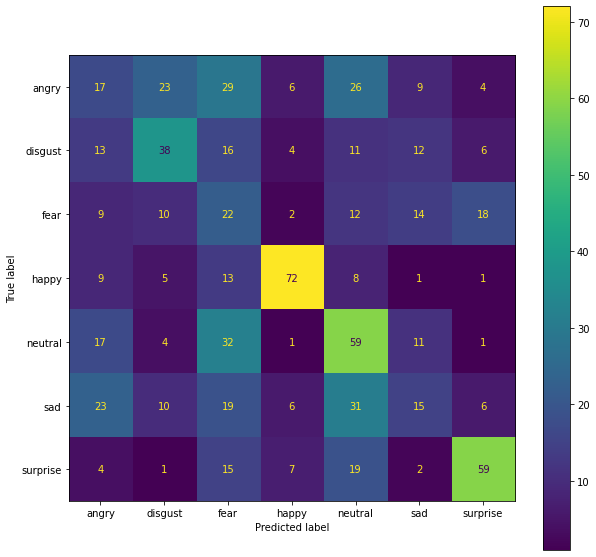

In [10]:
cm = confusion_matrix(fer2013_ytrain, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp = disp.plot(ax = ax)

### **Part 2 : Support Vector Machine**
#### Classify the images from FER2013 using an SVM. Use 5-fold cross-validation to report the performance. Report precision, recall, accuracy, F1 score, and create a confusion matrix.

In [11]:
svmModel = SVC(kernel = "rbf") #default "rbf" reports best performance

In [12]:
y_pred = cross_val_predict(svmModel, fer2013_xtrain, fer2013_ytrain, cv = skf) #Using Skf defined in the above section here as well
precision, recall, f1score, _ = precision_recall_fscore_support(fer2013_ytrain, y_pred, average = "micro") #Same as in GMM

In [13]:
accuracy = accuracy_score (fer2013_ytrain, y_pred)

#### Reporting Scores

In [14]:
print("\nPrecision Score = ", precision)
print("Recall Score =", recall)
print("f1 score =", f1score)
print("Accuracy Score =", accuracy, "\n")


Precision Score =  0.4428191489361702
Recall Score = 0.4428191489361702
f1 score = 0.4428191489361702
Accuracy Score = 0.4428191489361702 



### Confusion Matrix

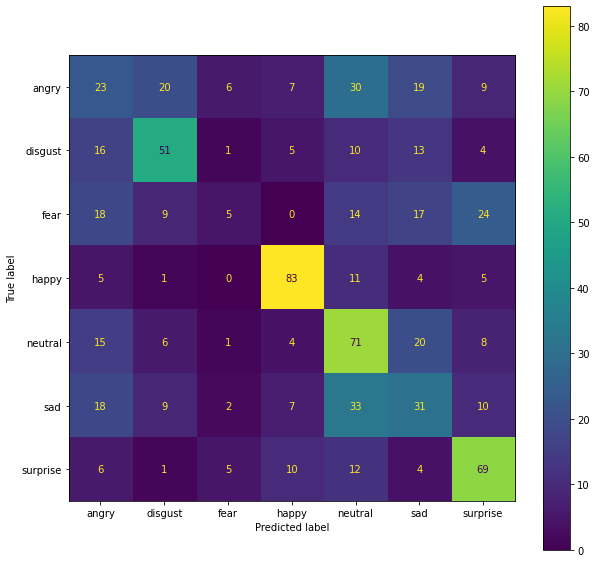

In [15]:
cm = confusion_matrix(fer2013_ytrain, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

fig, ax = plt.subplots(figsize=(10,10))
disp = disp.plot(ax = ax)

### **Part 3: Compare** 
#### **Compare the results from the 2 models SVM and GMM. Choose the one that you think worked best with this dataset. Justify your answer based on the results from the evaluation step**.

Let us compare the two models on various aspects      
*  Understanding the scores 
   > The scores in various iterations seems to have an average difference over 0.08 - 0.12 where SVM performs slightly better than GMM. The reason could be that GMM creates assumptions and evaluates based on the  combination Probability Distribution Functions of each class. SVM, however, simply calculates distances between the nodes to evaluate cluster information where closer points are more likely to be in the same cluster. GMM can provide better information about how variables are related to each other, however for training, it seems SVM performs better using a simple distance metric
   
*  Confusion Matrix
    > The confusion matrices give an interesting perspective of what the models think when they predict on each data. In the GMM Matrix, we can observe that the predictions are more distributed and unlikely to be highly accurate, the distributions are not very concentrated on the diagonals (Correct Predictions) especially on the anger, fear and sad classes. The SVM on the other hand, is highly concentrated on the diagonal but completely fails to predict the fear class and is somewhat conflicted on fear and anger but still better than GMM. The fear class has the lowest prevalance in the dataset which might be the reason in SVM's prediction skew. 
    
#### Why is GMM < SVM
Possibly because it is not very well suited to classification as an SVM model. However, due to the limitation of the dataset, on the basis of how accurate the AU data is, even SVM fails to categorize a few classes perfectly. 
#### Why are accuracies low? 
(This applies to both) It could be due to the fact that there exists smaller distinctions between the classes like angry sad and neutral making them harder to predict than classes like happy and surprised. Also given the dataset is not large, the model hasnt had enough exposure to make better predictions). In machine learning, the amount of data and its correctness related to its outcome are paramount


### **Part 4: Classifying the Phoebe Dataset on the SVM model**

In [16]:
phoebe = pd.read_csv ("./Phoebe/phoebe.csv")

#### Dropping the unknown labels after saving them in another DataFrame

In [17]:
phoebe_df = phoebe.drop([" confidence", "file_name"], axis=1)
phoebe_labels = phoebe_df["label"]
phoebe_label_unknown = phoebe_df[phoebe_df["label"] == 'unknown']
phoebe_df = phoebe_df[phoebe_df["label"] != 'unknown']
phoebe_df = phoebe_df.reset_index(drop = True)

In [18]:
phoebe_all_data = phoebe_df.drop("label", axis = 1)
phoebe_all_label = phoebe_df ["label"]

#### Standardizing the Phoebe data to predict on  
> (The model is trained on standardized data, feeding it unstandarized data will reduce accuracy)

In [19]:
scaler = StandardScaler()
scaled = scaler.fit_transform(phoebe_all_data)

In [20]:
phoebe_all_data = pd.DataFrame(scaled, index = phoebe_all_data.index, columns = phoebe_all_data.columns)

### Fitting the Model on FER2013 and trying to predict on Phoebe's AUs

In [21]:
svmModel = SVC(kernel = "rbf") # Poly had a slightly lesser performance (was tested till degree = 20) RBF triumphs once again!
svmModel.fit (fer2013_xtrain, fer2013_ytrain)
phoebe_all_pred = svmModel.predict(phoebe_all_data)
 
phoebe_df ["pred"] = phoebe_all_pred
phoebe_df ["pred"] = label_encoder.inverse_transform(phoebe_all_pred)
phoebe_all_pred_txt = label_encoder.inverse_transform(phoebe_all_pred)

phoebe_all_label = pd.DataFrame (phoebe_all_label)
phoebe_all_pred_txt = pd.DataFrame (phoebe_all_pred_txt, columns = ["Predictions"])

precision, recall, f1score, _ = precision_recall_fscore_support(phoebe_all_label, phoebe_all_pred_txt, average = "micro") #Same as in GMM

In [22]:
print("\nPrecision Score = ", precision)
print("Recall Score =", recall)
print("f1 score =", f1score)
print("Accuracy Score =", accuracy_score (phoebe_all_pred_txt, phoebe_all_label), "\n")


Precision Score =  0.3333333333333333
Recall Score = 0.3333333333333333
f1 score = 0.3333333333333333
Accuracy Score = 0.3333333333333333 



**Reported Accuracy = 33%**

**Below are the Trues vs Predictions**

In [23]:
final = phoebe_all_label.join(phoebe_all_pred_txt)
final


,label,Predictions
0,angry,angry
1,surprise,neutral
2,happy,happy
3,sad,angry
4,sad,angry
...,...,...
85,sad,neutral
86,happy,happy
87,happy,sad
88,surprise,fear


#### **Predicting on the Unknown Values in Phoebe Data**

In [24]:
phoebe_label_unknown_predict = phoebe_label_unknown.drop("label", axis = 1)

predicted = svmModel.predict(phoebe_label_unknown_predict)

predicted_txt = label_encoder.inverse_transform(predicted) #Inverting Label Encoder to get back the string of the encoded numbers

In [25]:
predicted_txt = pd.DataFrame(predicted_txt, columns = ["Predicted"])

finalDF = pd.DataFrame(phoebe[phoebe["label"] == 'unknown'])
finalDF = finalDF.reset_index (drop = True)

finalDF = finalDF.join(predicted_txt)

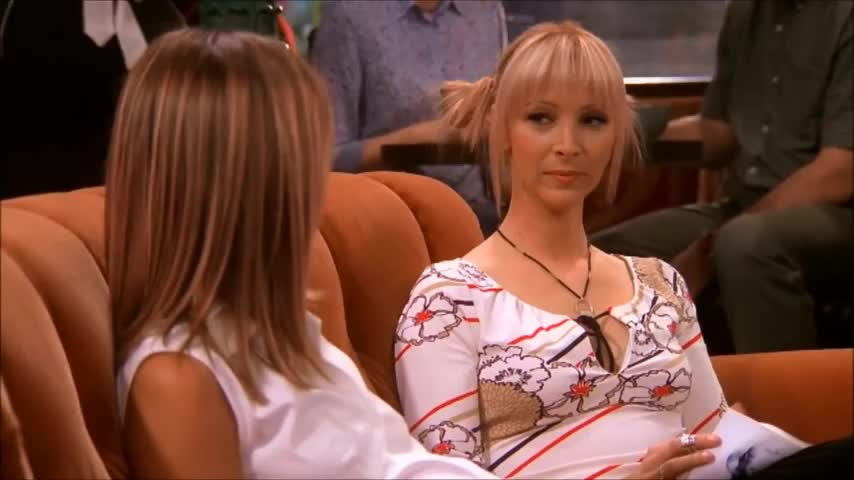

Predicted Emotion for Image Above = angry




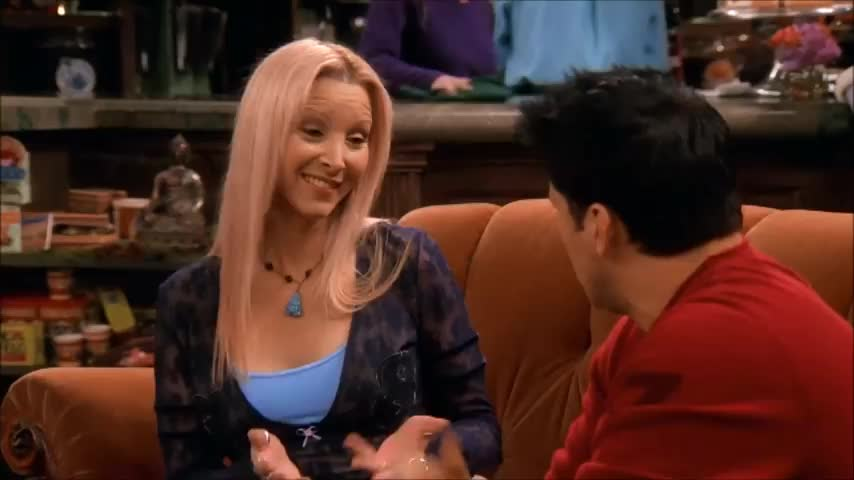

Predicted Emotion for Image Above = happy




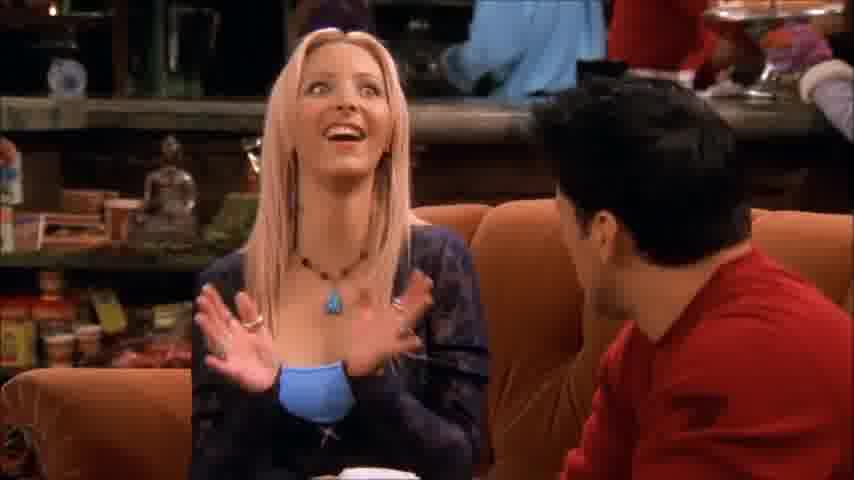

Predicted Emotion for Image Above = happy




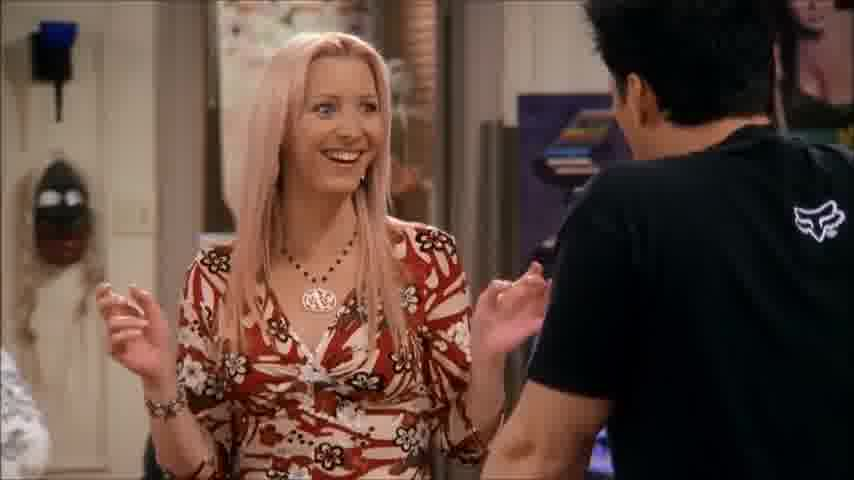

Predicted Emotion for Image Above = happy




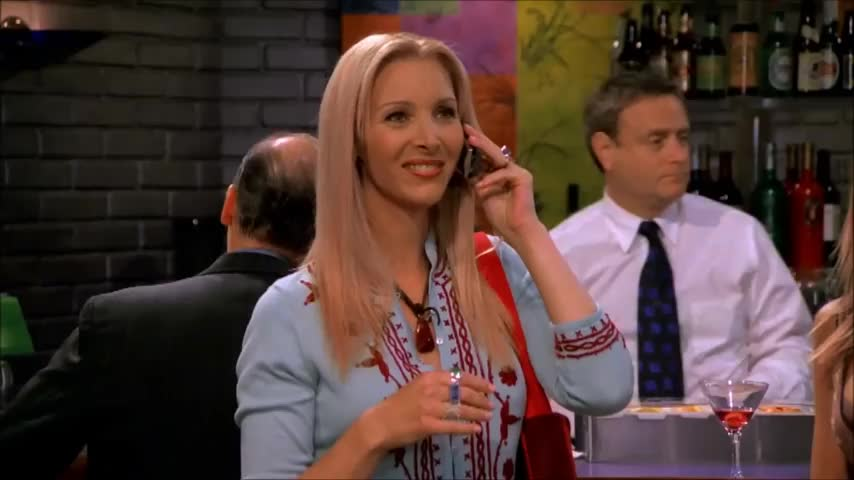

Predicted Emotion for Image Above = happy




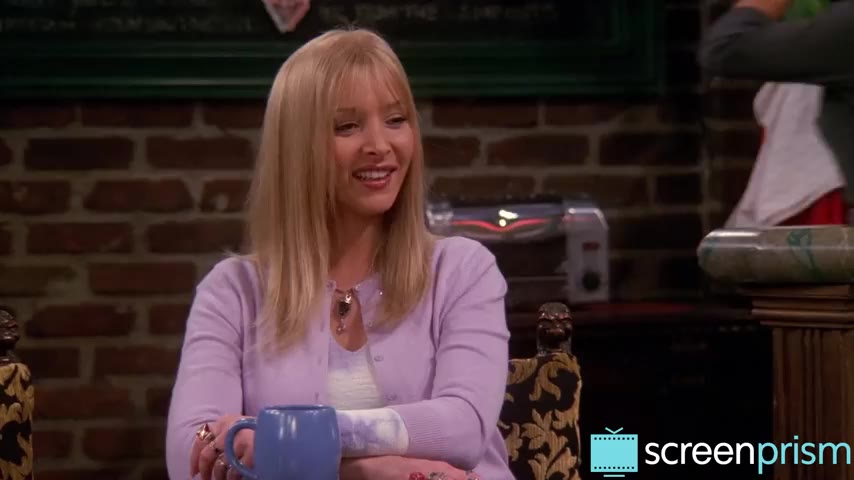

Predicted Emotion for Image Above = angry




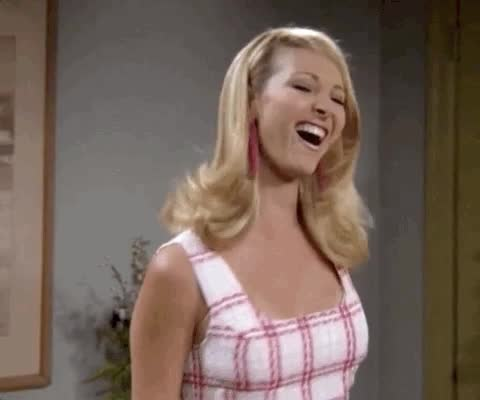

Predicted Emotion for Image Above = angry




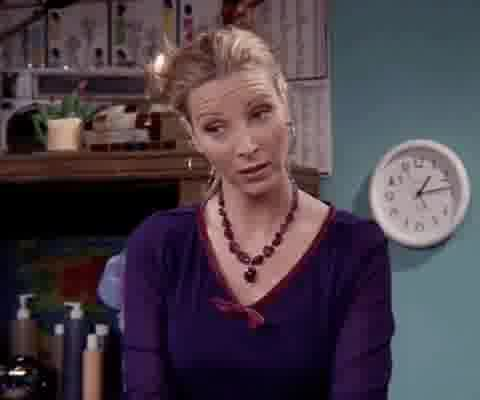

Predicted Emotion for Image Above = angry




In [26]:
dir = "./Phoebe/images/unknown"

for idx in range (len(finalDF["file_name"])):
    
    display(Image(filename=dir+"/"+finalDF["file_name"][idx]))
    print("Predicted Emotion for Image Above = " + finalDF["Predicted"][idx])
    print("\n")
    

> The labels seem appropriate for the Happy Emotion in Images (2,3,4 and 5), Image 1 looks annoyed which could lie in the same plane as angry, and Image 8 looks dissapproval which might also be categorized in anger. Images 7 and 6 seem inappropriate as the actual emotion is not angry at all, for Image 7, the eyelids are forcefully closed because of excitement but in AUs it could be representative of anger as in anger we tend to close eyes as well. <br>

## Let us now explore the reasons for inappropriate labels
- **Skew in Data** [Since there is a higher number of happy data, the data could appropriately guess atleast on images where Phoebe portrays happiness]

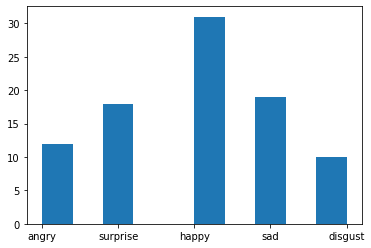

In [27]:
plt = plt.hist(phoebe_all_label)

## Limitations of using FER trained model to detect Phoebe's emotions
* The images in the FER2013 dataset are black and white, are centered on the face, the images have lower resolution and are without background context. All of these consistencies are not a part of the phoebe dataset which could explain the misappropriation. 
* I also tried training svm on phoebe's own data, which improved the results significantly, suggesting that FER2013's data is somehow only good enough to predict happiness in Phoebe's AUs, seeing the SVM data on FER2013 testing also suggests it is extremely good at True Positives for the Happy Class.
* The AU for phoebe could have different patterns in other emotions compared to FER, the models use AU info to derive inference, for classifying fer itself it works because the data is standardized on the differences mentioned in the first point. Basically what I mean is the AUs in phoebe's data could represent something else to a model train on FER2013. 


# END